se carga el dataset ya balanceado y el vectorizador TF-IDF que se generó en el notebook anterior

In [1]:
import pandas as pd
import joblib

df = pd.read_csv("/content/buzon_balanceado.csv")
vectorizador = joblib.load("/content/tfidf_vectorizer.pkl")

X = vectorizador.transform(df["comentario"])
y = df["etiqueta"]




aquí empieza la parte del entretamiento donde se dividen los datos en un conjunto de entrenamiento 80% y uno de prueba 20%

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


se entrena el modelo de regresión logística utilizando el parámetro class_weight="balanced" para dar mayor importancia a las clases menos frecuentes

In [3]:
from sklearn.linear_model import LogisticRegression

modelo = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

modelo.fit(X_train, y_train)



LogisticRegression(class_weight='balanced', max_iter=1000)

se genera la matriz de ocnfusión y el reporte de clasificación para analizar las métricas comúnes.

Para la clase *felicitación*, el modelo clasificó correctamente 14 comentarios. Sin embargo, 3 comentarios
que realmente eran felicitaciones fueron clasificados como quejas. No se observaron confusiones con la clase sugerencia,
lo que indica que el modelo distingue bien el lenguaje claramente positivo.

En la clase *queja*, 7 comentarios fueron clasificados correctamente. No obstante, 1 comentario fue confundido
con una felicitación y 2 con sugerencias. Esto sugiere que algunas quejas presentan un tono moderado que puede
parecer una sugerencia o incluso un comentario neutral.

En la clase *sugerencia*, el modelo clasificó correctamente 7 comentarios. Sin embargo, 6 sugerencias fueron
confundidas con quejas y 2 con felicitaciones. Esta es la clase con mayor nivel de confusión, lo cual es esperable
debido a que las sugerencias pueden contener críticas implícitas similares a las quejas.

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = modelo.predict(X_test)

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



Matriz de confusión:
[[14  3  0]
 [ 1  7  2]
 [ 2  6  7]]

Reporte de clasificación:
              precision    recall  f1-score   support

felicitación       0.82      0.82      0.82        17
       queja       0.44      0.70      0.54        10
  sugerencia       0.78      0.47      0.58        15

    accuracy                           0.67        42
   macro avg       0.68      0.66      0.65        42
weighted avg       0.72      0.67      0.67        42



Además del análisis numérico, se presentan representaciones gráficas que permiten una interpretación
más intuitiva del desempeño del modelo.



Para la clase **felicitación**, el modelo identifica correctamente 14 de los 17 comentarios reales. Sin embargo,
3 comentarios de felicitación fueron clasificados como queja. Esto da a interpretar que algunos comentarios positivos
contienen términos ambiguos que el modelo asocia con inconformidades.

En la clase **queja**, se observan 7 clasificaciones correctas. No obstante, 1 comentario fue clasificado como
felicitación y 2 como sugerencia. Este comportamiento refleja la dificultad del modelo para distinguir entre
una queja directa y una sugerencia expresada de forma crítica o moderada. De hecho, es la categoría con la que se tuvo que tratar de forma diferente ya que no había muchos datos con los cuales tratar.

La clase **sugerencia** presenta 7 aciertos, pero también muestra una confusión significativa con la clase queja,
con 6 comentarios clasificados erróneamente. Esto indica que ambas clases comparten patrones lingüísticos
similares, lo cual representa el principal reto del modelo.

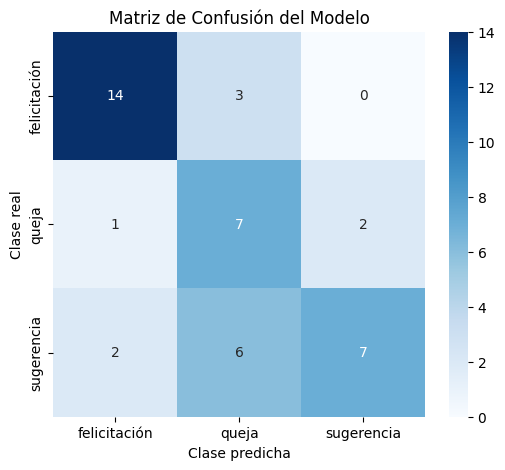

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular matriz
cm = confusion_matrix(y_test, y_pred)

# Etiquetas de clases
clases = modelo.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=clases,
    yticklabels=clases
)

plt.xlabel("Clase predicha")
plt.ylabel("Clase real")
plt.title("Matriz de Confusión del Modelo")
plt.show()


La clase **felicitación** muestra un muy buen desempeño y equilibrio, con valores altos y consistentes en las
tres métricas. Esto indica que el modelo reconoce adecuadamente los comentarios positivos y rara vez los
confunde con otras clases.

En el caso de la clase **queja**, el modelo presenta un recall relativamente alto, lo que significa que logra
identificar la mayoría de las quejas reales. Sin embargo, la precisión es baja, lo que indica que varias
predicciones de queja corresponden en realidad a otras categorías. Este comportamiento sugiere una
sobre-detección de la clase queja.

Para la clase **sugerencia**, la precisión es alta, lo que implica que cuando el modelo predice esta clase
generalmente acierta. No obstante, el recall es moderado, lo que indica que una parte importante de las
sugerencias reales no es correctamente identificada y se confunde principalmente con quejas.

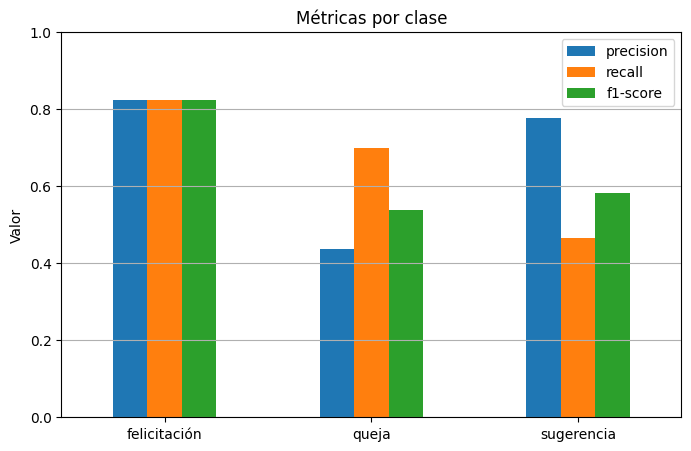

In [6]:
import pandas as pd
from sklearn.metrics import classification_report

# Convertir el reporte a DataFrame
reporte = classification_report(y_test, y_pred, output_dict=True)
df_reporte = pd.DataFrame(reporte).transpose()

# Seleccionar métricas relevantes
metricas = df_reporte.loc[clases, ["precision", "recall", "f1-score"]]

# Gráfica
metricas.plot(kind="bar", figsize=(8, 5))
plt.title("Métricas por clase")
plt.ylabel("Valor")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


In [7]:
joblib.dump(modelo, "/content/clasificador.pkl")



['/content/clasificador.pkl']

se diseña una función de predicción que recibe un texto cualquiera, lo procesa y devuelve la etiqueta predicha por el modelo

In [8]:
def clasificar_comentario(texto):
    texto = texto.lower().strip()
    X = vectorizador.transform([texto])
    return modelo.predict(X)[0]


In [9]:
print(clasificar_comentario("Muchas gracias por la excelente atención"))
print(clasificar_comentario("El trámite fue muy lento y no resolvieron nada"))
print(clasificar_comentario("Sería bueno ampliar el horario de atención"))


felicitación
queja
sugerencia


In [10]:
ejemplos = [
    "Excelente atención, el personal fue muy amable y resolvió mi problema rápido.",
    "Me encantó el servicio, todo fue claro y muy profesional. ¡Felicidades al equipo!",
    "El sistema es muy fácil de usar y funciona perfecto, sigan así.",
    "El pedido llegó tarde y nadie me dio una explicación, fue muy frustrante.",
    "La aplicación se traba constantemente y perdí información importante.",
    "El soporte tardó demasiado en responder y no solucionaron mi problema.",
    "Sería buena idea agregar un modo oscuro para usar la plataforma por la noche.",
    "Podrían mejorar los tiempos de respuesta y avisar cuando haya mantenimiento."
]

for comentario in ejemplos:
    print(f"Comentario: {comentario}")
    print("Clasificación:", clasificar_comentario(comentario))
    print("-" * 60)


Comentario: Excelente atención, el personal fue muy amable y resolvió mi problema rápido.
Clasificación: felicitación
------------------------------------------------------------
Comentario: Me encantó el servicio, todo fue claro y muy profesional. ¡Felicidades al equipo!
Clasificación: felicitación
------------------------------------------------------------
Comentario: El sistema es muy fácil de usar y funciona perfecto, sigan así.
Clasificación: queja
------------------------------------------------------------
Comentario: El pedido llegó tarde y nadie me dio una explicación, fue muy frustrante.
Clasificación: felicitación
------------------------------------------------------------
Comentario: La aplicación se traba constantemente y perdí información importante.
Clasificación: queja
------------------------------------------------------------
Comentario: El soporte tardó demasiado en responder y no solucionaron mi problema.
Clasificación: queja
-------------------------------------

se implementa una función para visualizar qué tan seguro está el modelo de su predicción, mostrando el porcentaje de pertenencia a cada clase.

El modelo no solo asigna una clase final, sino que también devuelve probabilidades asociadas a cada clase.
Por ejemplo, para un comentario dado se obtuvieron las siguientes probabilidades:

Felicitación: 0.16  
Queja: 0.57  
Sugerencia: 0.26  

Esto indica que el comentario tiene mayor afinidad con la clase queja, aunque también presenta características
asociadas a sugerencia. Esta ambigüedad es consistente con la confusión observada en la matriz de confusión.

El uso de probabilidades permite identificar comentarios ambiguos y puede ser aprovechado para establecer
umbrales de decisión o para alimentar modelos posteriores


In [11]:
def clasificar_con_prob(texto):
    X = vectorizador.transform([texto])
    clases = modelo.classes_
    probs = modelo.predict_proba(X)[0]
    return dict(zip(clases, probs))

print(clasificar_con_prob("El sistema no funciona y nadie responde"))


{'felicitación': np.float64(0.16470812637872181), 'queja': np.float64(0.5728564279780808), 'sugerencia': np.float64(0.2624354456431973)}


In [12]:
for texto in ejemplos:
    print("Comentario:")
    print(texto)
    print("Probabilidades por clase:")
    print(clasificar_con_prob(texto))
    print("-" * 60)


Comentario:
Excelente atención, el personal fue muy amable y resolvió mi problema rápido.
Probabilidades por clase:
{'felicitación': np.float64(0.4676581398496088), 'queja': np.float64(0.3370718556849954), 'sugerencia': np.float64(0.19527000446539594)}
------------------------------------------------------------
Comentario:
Me encantó el servicio, todo fue claro y muy profesional. ¡Felicidades al equipo!
Probabilidades por clase:
{'felicitación': np.float64(0.6757945609278019), 'queja': np.float64(0.15730229943891827), 'sugerencia': np.float64(0.16690313963327988)}
------------------------------------------------------------
Comentario:
El sistema es muy fácil de usar y funciona perfecto, sigan así.
Probabilidades por clase:
{'felicitación': np.float64(0.33304364516314444), 'queja': np.float64(0.377507027043252), 'sugerencia': np.float64(0.28944932779360366)}
------------------------------------------------------------
Comentario:
El pedido llegó tarde y nadie me dio una explicación, f

grafica de probabilidades para los comentarios

In [13]:
import matplotlib.pyplot as plt

def graficar_probabilidades(texto):
    probs = clasificar_con_prob(texto)

    clases = list(probs.keys())
    valores = list(probs.values())

    plt.figure()
    plt.bar(clases, valores)
    plt.ylim(0, 1)
    plt.title("Probabilidad por clase")
    plt.xlabel("Clase")
    plt.ylabel("Probabilidad")
    plt.show()


La gráfica representa la probabilidad asignada por el modelo de regresión
logística a cada una de las clases posibles para un comentario individual.
En este caso, la clase “queja” presenta la mayor probabilidad (≈0.57),
por lo que el modelo la selecciona como predicción final.

Sin embargo, también se observa una probabilidad considerable asociada
a la clase “sugerencia”, lo cual indica que el comentario comparte
características lingüísticas con más de una categoría. Este comportamiento
es esperado en textos reales, donde una queja puede incluir sugerencias
implícitas o constructivas.

La ausencia de probabilidades extremas refleja una clasificación prudente
por parte del modelo y evidencia tanto la complejidad del lenguaje natural
como las limitaciones derivadas del tamaño reducido del conjunto de datos.


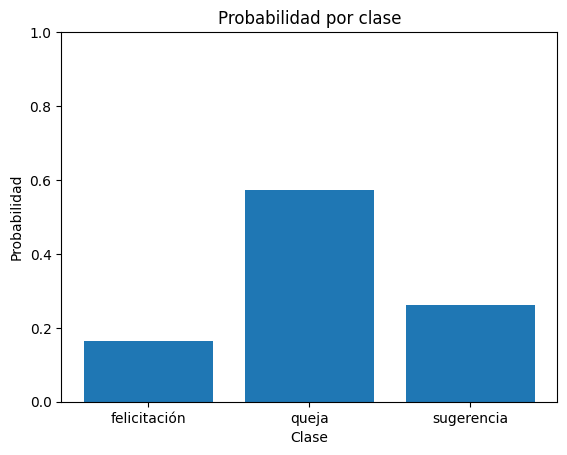

In [14]:
graficar_probabilidades("El sistema no funciona desde ayer y nadie responde")


El modelo logra cumplir adecuadamente su objetivo principal: clasificar automáticamente los comentarios
en felicitación, queja o sugerencia al momento de ser recibidos.

La clase felicitación es la mejor aprendida, mientras que la mayor dificultad se presenta al distinguir
entre sugerencias y quejas, debido a similitudes semánticas en el lenguaje utilizado.

A pesar de estas limitaciones, el modelo proporciona una base sólida para la segunda etapa del sistema,
en la cual los comentarios pueden ser canalizados al departamento correspondiente, utilizando tanto
la clase predicha como las probabilidades asociadas.